# Netflix Business Case Study

**Table of Content**
1. Import Libraries & Dataset
2. Data Investigation
3. Data Cleaning & Preprocessing
4. Statistical Summary
5. Exploratory Data Analysis (EDA)
6. Top 10 Insights & Recommendation

**Assumption:**
In this analysis, we used a dataset that lacks any metrics or numerical features to evaluate the performance or 
key performance indicators (KPIs) like views, critic's rating, boxoffice collection etc. of movies or shows.\
Therefore, we have considered that whatever the informarion/insights this dataset contains has worked for netflix.\
For instance, if we observe that the month of November has the highest number of movie releases, we can conclude that November is an ideal month for movie releases.

# Import Libraries and Dataset

In [516]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import random
import math

import warnings
warnings.filterwarnings('ignore')

In [517]:
df = pd.read_csv("original_netflix.csv")

In [518]:
df_raw = pd.read_csv("original_netflix.csv")

# Data Investigation

In [519]:
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [520]:
df.shape

(8807, 12)

In [521]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [522]:
# percentage of missing values in features
round((df.isna().sum()/df.shape[0])*100, 2)

show_id          0.00
type             0.00
title            0.00
director        29.91
cast             9.37
country          9.44
date_added       0.11
release_year     0.00
rating           0.05
duration         0.03
listed_in        0.00
description      0.00
dtype: float64

In [523]:
df.nunique()

show_id         8807
type               2
title           8804
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

In [524]:
# There is some duplicate values in title, 
# so we need to check whether the duplicate title is a duplicate row or not
title_value_cnt = df['title'].value_counts()
dup_index = title_value_cnt[title_value_cnt.values>1].index
df[df["title"].isin(dup_index)].iloc[:, 1:].duplicated()

3962    False
3996    False
4522    False
5964     True
5965     True
5966     True
dtype: bool

In [525]:
df["rating"].value_counts()

TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

**Issues in dataset**
1. show_id is a unique column and description columns gives a summary of the movie's/shows's plot which is related to NLP. So both the column will be dropped.
2. The dataset contains 3 duplicated rows. So that will be get dropped.
3. director, cast, country and listed_in columns has multiple values in single row. So that needs to be resolved.
4. The director, cast, country, date_added, rating, and duration columns contain null values. Instead of dropping the missing rows, which would result in the loss of information, we will utilize multiple imputation to fill the missing values.
5. rating colunm contains some unexpected value: 74 min, 84 min, 66 min. So we need to fix that also.
**All the above issues will be resolved in the Data Cleaning and Preprocessing section.**

# Data Cleaning & Preprocessing

## Dropping unnecessary Columns

In [526]:
df.drop(["show_id", "description"], axis=1, inplace=True)

In [527]:
df.shape

(8807, 10)

## Dropping duplicate rows

In [528]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [529]:
df.shape

(8804, 10)

## Unnesting the nested columns

In [530]:
print(df["country"].str.startswith(",").any())
print(df["country"].str.endswith(",").any())

True
True


In [531]:
# unitilty function for unnesting the column
# In the country column we have some values 
# that either starts with ',' or end with ','. So we also have to remove that
def return_unnested_df(main_df, sub_df, col_name):
    sub_df = sub_df.apply(lambda x: str(x).strip(", ").split(",")).\
    apply(lambda x : [s.strip() for s in x]).to_list()
    sub_df = pd.DataFrame(pd.DataFrame(sub_df, index=main_df["title"]).stack()).\
    reset_index().drop("level_1", axis=1)
    sub_df.columns = ["title", col_name]
    return sub_df

In [532]:
nested_columns = ["director", "cast", "country", "listed_in"]
sub_df = None
for i, col in enumerate(nested_columns):
    col_df = df.loc[:, col]
    col_df = return_unnested_df(df, col_df, col)
    if i==0:
        sub_df = col_df
    else:
        sub_df = sub_df.merge(col_df, on="title", how="inner")
df.drop(nested_columns, axis=1, inplace=True)
df = df.merge(sub_df, on="title", how="inner")

In [533]:
df.shape

(201873, 10)

In [534]:
df.head()

,type,title,date_added,release_year,rating,duration,director,cast,country,listed_in
0,Movie,Dick Johnson Is Dead,"September 25, 2021",2020,PG-13,90 min,Kirsten Johnson,nan,United States,Documentaries
1,TV Show,Blood & Water,"September 24, 2021",2021,TV-MA,2 Seasons,nan,Ama Qamata,South Africa,International TV Shows
2,TV Show,Blood & Water,"September 24, 2021",2021,TV-MA,2 Seasons,nan,Ama Qamata,South Africa,TV Dramas
3,TV Show,Blood & Water,"September 24, 2021",2021,TV-MA,2 Seasons,nan,Ama Qamata,South Africa,TV Mysteries
4,TV Show,Blood & Water,"September 24, 2021",2021,TV-MA,2 Seasons,nan,Khosi Ngema,South Africa,International TV Shows


In [535]:
df[df["country"]==""]["country"].any()

False

## Imputing missing values (Multiple Imputation)

In [536]:
df.isnull().sum()

type              0
title             0
date_added      158
release_year      0
rating           67
duration          3
director          0
cast              0
country           0
listed_in         0
dtype: int64

In [537]:
# here all the NaN values are not shown 
# because unnesting converted all the NaN values into "nan"
print("director:", df[df["director"]=="nan"].shape[0])
print("cast:", df[df["cast"]=="nan"].shape[0])
print("country:", df[df["country"]=="nan"].shape[0])

director: 50615
cast: 2146
country: 11877


In [538]:
# replacing "nan" with np.nan
df["director"].replace("nan", np.nan, inplace=True)
df["cast"].replace("nan", np.nan, inplace=True)
df["country"].replace("nan", np.nan, inplace=True)

In [539]:
df.isnull().sum()

type                0
title               0
date_added        158
release_year        0
rating             67
duration            3
director        50615
cast             2146
country         11877
listed_in           0
dtype: int64

missing values column
1. director
2. cast
3. country
4. date_added
5. rating
6. duration

### Imputing "country" column based on type

In [540]:
df["country"].fillna(df.groupby("type")["country"]\
                     .transform(lambda x :x.mode()[0]), inplace=True)

In [541]:
df["country"].isnull().sum()

0

### Imputing "director" column based on type, country and release_year

1. Since the range of release_year is from 1925 to 2022, it is unlikely that actors or directors would remain active for a span of around 96 years. Typically, actors and directors have their prime working years. Therefore, for imputation purposes, the release year can be divided into periods of 10 years to better reflect the active working periods of individuals.

2. We have also taken into account the type and country for imputation. This is because actors or directors who primarily work in movies tend to have fewer roles in TV shows. Similarly, actors or directors who primarily work in tv shows tend to have fewer roles in movies. Also actors/directors often work in their regional movies/TV shows in their native language.

3. It is crucial to note that the director column for TV shows has a significant proportion of missing values, approximately 91%. Among the 20 TV shows from Argentina, only 2 shows have a specified director's name. As a result, any analysis involving the director of TV shows may not be entirely accurate due to the extensive number of missing values. To address this issue, a possible approach is to impute the missing entries in the director column for TV shows with the value "unknown".

In [542]:
def return_period_df(df, period_len):
    year_start = df["release_year"].min()
    year_end = df["release_year"].max()
    year_range = year_end - year_start
    modulo = year_range%period_len
    final_start = year_end - modulo
    if modulo==0:
        final_start = year_end-period_len
    final_end = year_end+1
    periods_starting_year = np.arange(year_start, final_start, period_len)
    periods_tuple = [(year, year+period_len-1) for year in periods_starting_year]
    periods_tuple.append((final_start, final_end))
    bins = pd.IntervalIndex.from_tuples(periods_tuple, closed="both")
    df["periods"]=pd.cut(df["release_year"], bins=bins, include_lowest=True, precision=0)
    return df

In [543]:
def mode(x):
    try:
        ans = x.mode()[0]
    except:
        ans = "Unknown"
    return ans

In [544]:
def unknown_cnt(df, col1, col2, val):
    return df[(df[col1]==val) & (df[col2]=="Unknown")][col].shape[0]

In [545]:
def missing_values_percentage(col1, col2, val):
    label= f"Percentage of missing values in {col2} column for {val}: "
    value = round((df_raw[df_raw[col1]==val][col2].isnull().sum())/\
                  (df_raw[df_raw[col1]==val].shape[0]), 5)
    return label+str(value)+"%"

In [546]:
print(missing_values_percentage("type", "director", "Movie"))

Percentage of missing values in director column for Movie: 0.03066%


In [547]:
print(missing_values_percentage("type", "director", "TV Show"))

Percentage of missing values in director column for TV Show: 0.91405%


In [548]:
df = return_period_df(df, 10)

In [549]:
# imputing director coulmn
df["director"].fillna(df.groupby(["type", "country", "periods"])["director"]\
                      .transform(mode), inplace=True)

In [550]:
df["director"].isnull().sum()

0

In [551]:
movie_unknown = unknown_cnt(df, "type", "director", "Movie")
show_unknown = unknown_cnt(df, "type", "director", "TV Show")
print(f"Movie Unknown Director: {movie_unknown}")
print(f"TV Show Unknown Director: {show_unknown}")

Movie Unknown Director: 0
TV Show Unknown Director: 5161


### Imputing "cast" column based on type, country and release_year

Similar to director column, the cast column will be imputed

In [552]:
print(missing_values_percentage("type", "cast", "Movie"))
print(missing_values_percentage("type", "cast", "TV Show"))

Percentage of missing values in cast column for Movie: 0.07748%
Percentage of missing values in cast column for TV Show: 0.13079%


In [553]:
# imputing cast column
df["cast"].fillna(df.groupby(["type", "country", "periods"])["cast"]\
                  .transform(mode), inplace=True)

In [554]:
df["cast"].isnull().sum()

0

In [555]:
movie_unknown = unknown_cnt(df, "type", "cast", "Movie")
show_unknown = unknown_cnt(df, "type", "cast", "TV Show")
print(f"Movie Unknown cast: {movie_unknown}")
print(f"TV Show Unknown cast: {show_unknown}")

Movie Unknown cast: 22
TV Show Unknown cast: 11


### Imputing "rating" column based on type, country and release_year

For rating column, again we are going to same technique that are used in director and cast columns

In [556]:
print(missing_values_percentage("type", "rating", "Movie"))
print(missing_values_percentage("type", "rating", "TV Show"))

Percentage of missing values in rating column for Movie: 0.00033%
Percentage of missing values in rating column for TV Show: 0.00075%


In [557]:
# imputing rating column
df["rating"].fillna(df.groupby(["type", "country", "periods"])["rating"]\
                    .transform(mode), inplace=True)

In [558]:
df["rating"].isnull().sum()

0

In [559]:
movie_unknown = unknown_cnt(df, "type", "rating", "Movie")
show_unknown = unknown_cnt(df, "type", "rating", "TV Show")
print(f"Movie Unknown rating: {movie_unknown}")
print(f"TV Show Unknown rating: {show_unknown}")

Movie Unknown rating: 0
TV Show Unknown rating: 0


### Imputing "duration" column based on type, country and release_year

To process the duration values in the dataset:

1. The duration of movies is given in minutes, while the duration of TV shows is specified in seasons.

2. The values for both movies and TV shows are in string format, such as "90 min" for movies and "2 Seasons" for TV shows. To extract the numerical part of the duration, the strings will be sliced, and only the numerical values will be stored as the duration. For example, a movie with a duration of "90 min" will be stored as 90, representing 90 minutes. Similarly, a TV show with a duration of "2 Seasons" will be stored as 2, representing 2 seasons.

3. TV shows do not have any missing values in the duration column, so the imputation process will only be applied to movies.

4. The same imputation technique used for the director and cast columns can be utilized for the movie duration column.

In [560]:
print(missing_values_percentage("type", "duration", "Movie"))
print(missing_values_percentage("type", "duration", "TV Show"))

Percentage of missing values in duration column for Movie: 0.00049%
Percentage of missing values in duration column for TV Show: 0.0%


In [561]:
df[df["type"]=="Movie"]["duration"].unique()

array(['90 min', '91 min', '125 min', '104 min', '127 min', '67 min',
       '94 min', '161 min', '61 min', '166 min', '147 min', '103 min',
       '97 min', '106 min', '111 min', '110 min', '105 min', '96 min',
       '124 min', '116 min', '98 min', '23 min', '115 min', '122 min',
       '99 min', '88 min', '100 min', '102 min', '93 min', '95 min',
       '85 min', '83 min', '113 min', '13 min', '182 min', '48 min',
       '145 min', '87 min', '92 min', '80 min', '117 min', '128 min',
       '119 min', '143 min', '114 min', '118 min', '108 min', '63 min',
       '121 min', '142 min', '154 min', '120 min', '82 min', '109 min',
       '101 min', '86 min', '229 min', '76 min', '89 min', '156 min',
       '112 min', '107 min', '129 min', '135 min', '136 min', '165 min',
       '150 min', '133 min', '70 min', '84 min', '140 min', '78 min',
       '64 min', '59 min', '139 min', '69 min', '148 min', '189 min',
       '141 min', '130 min', '138 min', '81 min', '132 min', '123 min',
       '65

In [562]:
df[df["type"]=="TV Show"]["duration"].unique()

array(['2 Seasons', '1 Season', '9 Seasons', '4 Seasons', '5 Seasons',
       '3 Seasons', '6 Seasons', '7 Seasons', '10 Seasons', '8 Seasons',
       '17 Seasons', '13 Seasons', '15 Seasons', '12 Seasons',
       '11 Seasons'], dtype=object)

In [563]:
# removing min and season from df
df["duration"] = df["duration"].apply(lambda x : str(x).split(" ")[0]).astype("float")

In [564]:
# imputing nan values of "duration" column
df["duration"].fillna(df.groupby(["type", "country", "periods"])["duration"]\
                      .transform("mean"), inplace=True)

In [565]:
# changing dtype of duration column to int
df["duration"] = df["duration"].astype("int64")

In [566]:
df["duration"].isnull().sum()

0

In [567]:
df.isnull().sum()

type              0
title             0
date_added      158
release_year      0
rating            0
duration          0
director          0
cast              0
country           0
listed_in         0
periods           0
dtype: int64

### Imputing "date_added" column based on type and country

* **Imputation Technique** \
For the imputation technique, only the type and country columns will be considered. This decision is based on the following reasons:

1. The type column is used to differentiate between movies and TV shows. Movies are typically released in theaters before being listed on Netflix, while TV shows can be Netflix's original series or previously aired TV shows. Therefore, the time difference between the release year and the listed date can vary significantly for movies and TV shows.

2. The country column is taken into account because Netflix expands its services to different countries at different times. For instance, Netflix started its subscription-based model in the USA in 1999, while it launched in India in 2016. This means that a movie released in 1970 may have been listed on Netflix in the USA in 1999, but it would only be listed in India after 2016 since it is an Indian movie.

Considering these factors, the imputation technique will consider the type and country columns to handle missing values or make decisions based on these specific attributes.


* **Imputation Value**\
The median of difference between released date and date added will be used as an imputation value for each type and country. Here we have only released year information. So 1st January of each year will be considered as the release date.\
e.g.\
release_year = 2016\
date_added = 02/02/2017\
so, diff = 02/02/2017 - 01/01/2016

In [568]:
print(missing_values_percentage("type", "date_added", "Movie"))
print(missing_values_percentage("type", "date_added", "TV Show"))

Percentage of missing values in date_added column for Movie: 0.0%
Percentage of missing values in date_added column for TV Show: 0.00374%


In [569]:
# converting date_added column to datetime
df["date_added"] = pd.to_datetime(df["date_added"])

In [570]:
# adding one column as release_date to store 
# the release_year (2019) as release_date (01/01/2019)
df["release_date"] = df["release_year"].apply(lambda x: pd.to_datetime("01/01/"+str(x)))

In [571]:
# adding one column date_diff to store the difference between release_date and added_date
df["date_diff"] = df.apply(lambda x: (x["date_added"]-x["release_date"])/\
                           np.timedelta64(1, "D"), axis=1)

In [572]:
# calculating the median of the date_diff for each country and type, 
# and merging median df to original df
df_median = df.groupby(["type", "country"])["date_diff"].apply("median").reset_index()
df=df.merge(df_median, on=["type", "country"], how="inner").drop(["date_diff_x"], axis=1).\
rename({"date_diff_y": "date_diff_median"}, axis=1)

In [573]:
# utility function to impute the missing value
def date_add_impute(date_added, release_date, median):
    if date_added == date_added:
        return date_added
    limit = pd.to_datetime("2023/01/01")
    date_added = release_date + pd.DateOffset(days=median)
    date_added = min(limit, date_added)
    return date_added

In [574]:
df["date_added"] = df.apply(lambda x : \
date_add_impute(x["date_added"], x["release_date"], x["date_diff_median"]), axis=1)

In [575]:
df.isnull().sum()

type                0
title               0
date_added          0
release_year        0
rating              0
duration            0
director            0
cast                0
country             0
listed_in           0
periods             0
release_date        0
date_diff_median    0
dtype: int64

In [576]:
# dropping the extra added column release_date and date_diff_median
df.drop(["release_date", "date_diff_median"], axis=1, inplace=True)

## Replacing unexpected value in "rating" column with mode

Only 3 rows in the rating column have unexpected values (74 min, 84 min, and 66 min). Since the percentage of these unexpected values is very low, they can be replaced by the mode (most common value) of the rating column. It is important to note that these records are from the Movie type and United States country.

In [577]:
mode_val = df[(df["type"]=="Movie") & (df["country"]=="United States")]["rating"].mode()[0]
df["rating"].replace(["74 min", "84 min", "66 min"], mode_val, inplace=True)

In [578]:
df

,type,title,date_added,release_year,rating,duration,director,cast,country,listed_in,periods
0,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,Kirsten Johnson,James Franco,United States,Documentaries,"[2015, 2022]"
1,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,Vanessa Hudgens,United States,Children & Family Movies,"[2015, 2022]"
2,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,Kimiko Glenn,United States,Children & Family Movies,"[2015, 2022]"
3,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,James Marsden,United States,Children & Family Movies,"[2015, 2022]"
4,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,Sofia Carson,United States,Children & Family Movies,"[2015, 2022]"
...,...,...,...,...,...,...,...,...,...,...,...
201868,Movie,You Carry Me,2016-07-01,2015,TV-MA,157,Ivona Juka,Sebastian Cavazza,Montenegro,International Movies,"[2015, 2022]"
201869,Movie,You Carry Me,2016-07-01,2015,TV-MA,157,Ivona Juka,Ana Begic,Montenegro,Dramas,"[2015, 2022]"
201870,Movie,You Carry Me,2016-07-01,2015,TV-MA,157,Ivona Juka,Ana Begic,Montenegro,International Movies,"[2015, 2022]"
201871,Movie,You Carry Me,2016-07-01,2015,TV-MA,157,Ivona Juka,Krunoslav Saric,Montenegro,Dramas,"[2015, 2022]"


## Extracting Year, Month, Day and year_diff from "date_added" column for EDA

In [579]:
df["year_added"] = df["date_added"].apply(lambda x : x.year)
df["month_added"] = df["date_added"].apply(lambda x : x.month_name())
df["day_added"] = df["date_added"].apply(lambda x : x.day_name())

In [580]:
df["year_diff"] = df["year_added"] - df["release_year"]

In [581]:
df.head()

,type,title,date_added,release_year,rating,duration,director,cast,country,listed_in,periods,year_added,month_added,day_added,year_diff
0,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,Kirsten Johnson,James Franco,United States,Documentaries,"[2015, 2022]",2021,September,Saturday,1
1,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,Vanessa Hudgens,United States,Children & Family Movies,"[2015, 2022]",2021,September,Friday,0
2,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,Kimiko Glenn,United States,Children & Family Movies,"[2015, 2022]",2021,September,Friday,0
3,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,James Marsden,United States,Children & Family Movies,"[2015, 2022]",2021,September,Friday,0
4,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,Robert Cullen,Sofia Carson,United States,Children & Family Movies,"[2015, 2022]",2021,September,Friday,0


**Four new columns are added into the dataset for the EDA**
1. **year_added**: year in which the item was added into Netflix library
2. **month_added**: month in which the item was added into Netflix library
3. **Day_added**: day on which the item was added into Netflix platform
4. **year_diff**: difference between the release_year and year_added
5. **periods**: It divides the entire dataset into a bins of 10 years. this bins are made from release_year

## Exporting clean df into a .cvs file

In [582]:
# order of column in exported df
column_order = [0, 1, 6, 7, 5, 4, 9, 8, 3, 11, 12, 13, 2, 14, 10]

In [583]:
df = df.iloc[:, column_order]

In [584]:
df.to_csv("netflix_preprocessed.csv", index=False)

# Importing preprocessed data

In [585]:
df = pd.read_csv("netflix_preprocessed.csv")

In [586]:
df.head()

,type,title,director,cast,duration,rating,listed_in,country,release_year,year_added,month_added,day_added,date_added,year_diff,periods
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,James Franco,90,PG-13,Documentaries,United States,2020,2021,September,Saturday,2021-09-25,1,"[2015, 2022]"
1,Movie,My Little Pony: A New Generation,Robert Cullen,Vanessa Hudgens,91,PG,Children & Family Movies,United States,2021,2021,September,Friday,2021-09-24,0,"[2015, 2022]"
2,Movie,My Little Pony: A New Generation,Robert Cullen,Kimiko Glenn,91,PG,Children & Family Movies,United States,2021,2021,September,Friday,2021-09-24,0,"[2015, 2022]"
3,Movie,My Little Pony: A New Generation,Robert Cullen,James Marsden,91,PG,Children & Family Movies,United States,2021,2021,September,Friday,2021-09-24,0,"[2015, 2022]"
4,Movie,My Little Pony: A New Generation,Robert Cullen,Sofia Carson,91,PG,Children & Family Movies,United States,2021,2021,September,Friday,2021-09-24,0,"[2015, 2022]"


In [587]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201873 entries, 0 to 201872
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   type          201873 non-null  object
 1   title         201873 non-null  object
 2   director      201873 non-null  object
 3   cast          201873 non-null  object
 4   duration      201873 non-null  int64 
 5   rating        201873 non-null  object
 6   listed_in     201873 non-null  object
 7   country       201873 non-null  object
 8   release_year  201873 non-null  int64 
 9   year_added    201873 non-null  int64 
 10  month_added   201873 non-null  object
 11  day_added     201873 non-null  object
 12  date_added    201873 non-null  object
 13  year_diff     201873 non-null  int64 
 14  periods       201873 non-null  object
dtypes: int64(4), object(11)
memory usage: 23.1+ MB


# Statistical Summary

## Outliers in "duration" column

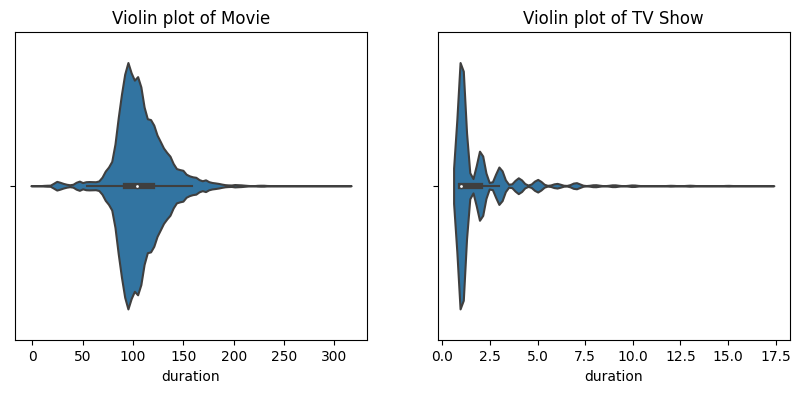

In [588]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.violinplot(data=df[df["type"]=="Movie"], x="duration")
plt.title("Violin plot of Movie")
plt.subplot(1,2,2)
sns.violinplot(data=df[df["type"]=="TV Show"], x="duration")
plt.title("Violin plot of TV Show")
plt.show()

* It is observed that there are high outliers in the duration of both movies and TV shows. These outliers represent instances where the duration of certain movies or TV shows deviates significantly from the average or expected duration

## Five points summary

In [589]:
df[df["type"]=="Movie"]["duration"].describe()

count    145753.000000
mean        106.843372
std          24.694846
min           3.000000
25%          93.000000
50%         104.000000
75%         119.000000
max         312.000000
Name: duration, dtype: float64

## Correlation

<AxesSubplot: >

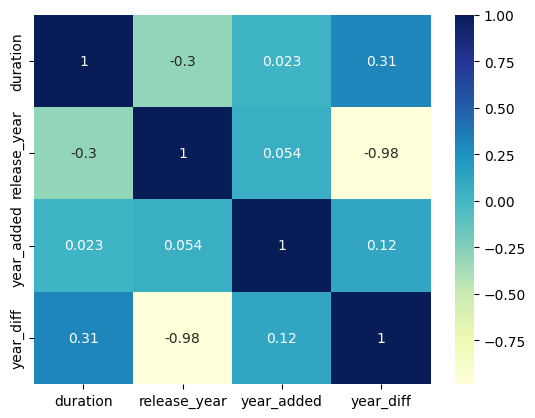

In [590]:
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

1. Duration and year_diff (the difference between year_added and release_year) are weakly positively correlated. This implies that, on average, as the duration of a movie or TV show increases, the difference in years between its release and when it was added to Netflix also tends to increase. However, the correlation between these two variables is not particularly strong.

2. It is logical to expect a negative correlation between release_year and year_diff. As the release_year of a movie or TV show increases, the year_diff (the difference between year_added and release_year) decreases. This is because the year_added is the year when the content was added to Netflix, and as time progresses, the year_diff naturally becomes smaller. Therefore, an increase in release_year generally leads to a decrease in year_diff.

# Exploratory Data Analysis (EDA)

## Basic EDA

### 1. Top 5 countries with highest number of contents (both movies and tv shows)

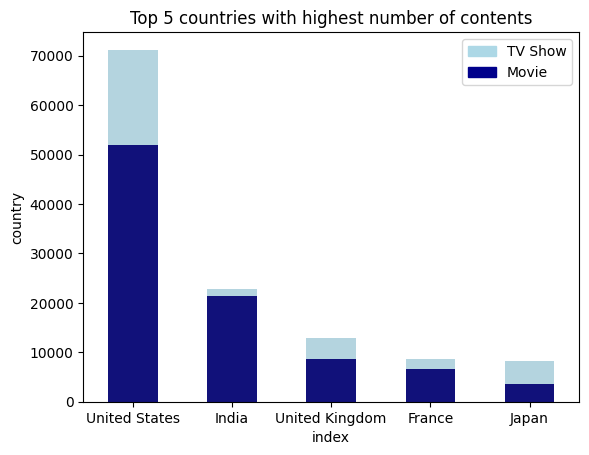

In [591]:
top_5_total_cnt = df.groupby(["country"]).size().reset_index()\
.sort_values(0, ascending=False).iloc[:5]
top_5_movie_cnt = top5_tv_show = \
df[(df["country"].isin(top_5_total_cnt["country"])) & (df["type"]=="Movie")]["country"]\
.value_counts().reset_index()

#plot
sns.barplot(x="country",  y=0, data=top_5_total_cnt, color="lightblue", width=0.5)
sns.barplot(x="index", y="country", data=top_5_movie_cnt,  color="darkblue", width=0.5)
top_bar = mpatches.Patch(color="lightblue", label="TV Show")
bottom_bar = mpatches.Patch(color="darkblue", label="Movie")
plt.legend(handles=[top_bar, bottom_bar])
plt.title("Top 5 countries with highest number of contents")
plt.show()

### 2. Top 5 countries with highest number of movies and tv shows separately

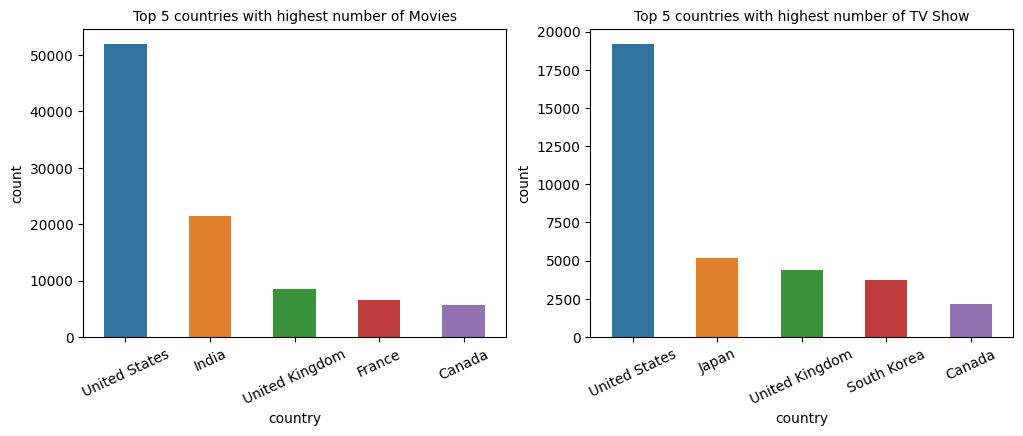

In [592]:
movie_order_idx = df[df["type"]=="Movie"]["country"].value_counts().iloc[:5].index
show_order_idx = df[df["type"]=="TV Show"]["country"].value_counts().iloc[:5].index
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(data=df[df["type"]=="Movie"], x="country", order=movie_order_idx, width=0.5)
plt.title("Top 5 countries with highest number of Movies", fontsize=10)
plt.xticks(rotation=25)
plt.subplot(1,2,2)
sns.countplot(data=df[df["type"]=="TV Show"], x="country", order=show_order_idx, width=0.5)
plt.title("Top 5 countries with highest number of TV Show", fontsize=10)
plt.xticks(rotation=25)
plt.show()

### 3. Top 5 rating with highest number of contents (both movies and tv shows)

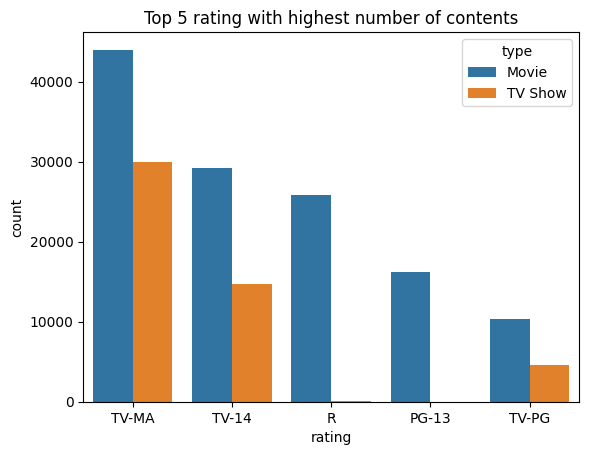

In [593]:
order_idx = df["rating"].value_counts().iloc[:5].index
sns.countplot(data=df, x="rating", order=order_idx, hue="type")
plt.title("Top 5 rating with highest number of contents")
plt.show()

### 4. Top 5 genre with highest number of movies and tv shows separately

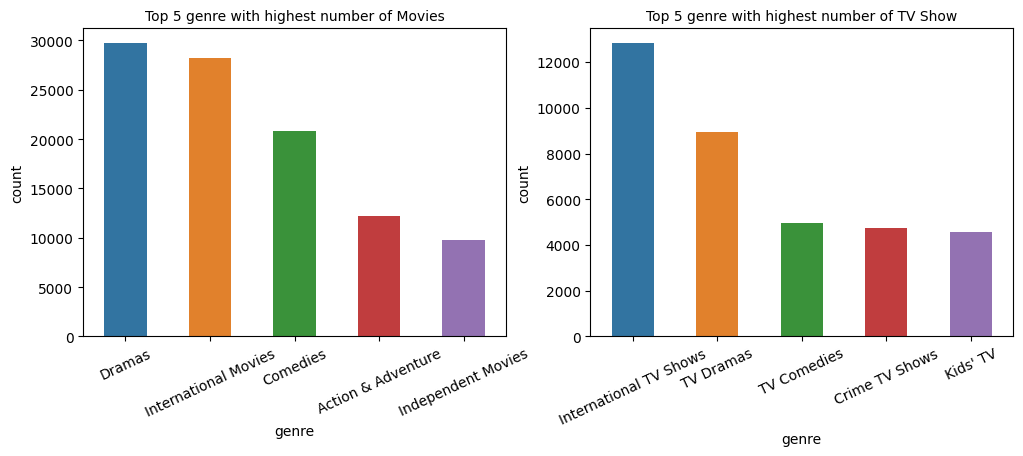

In [594]:
movie_order_idx = df[df["type"]=="Movie"]["listed_in"].value_counts().iloc[:5].index
show_order_idx = df[df["type"]=="TV Show"]["listed_in"].value_counts().iloc[:5].index
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(data=df[df["type"]=="Movie"], x="listed_in", order=movie_order_idx, width=0.5)
plt.title("Top 5 genre with highest number of Movies", fontsize=10)
plt.xlabel("genre")
plt.xticks(rotation=25)
plt.subplot(1,2,2)
sns.countplot(data=df[df["type"]=="TV Show"],x="listed_in",order=show_order_idx,width=0.5)
plt.title("Top 5 genre with highest number of TV Show", fontsize=10)
plt.xlabel("genre")
plt.xticks(rotation=25)
plt.show()

## Indepth EDA

### 1. Trend of movies and tv shows over time

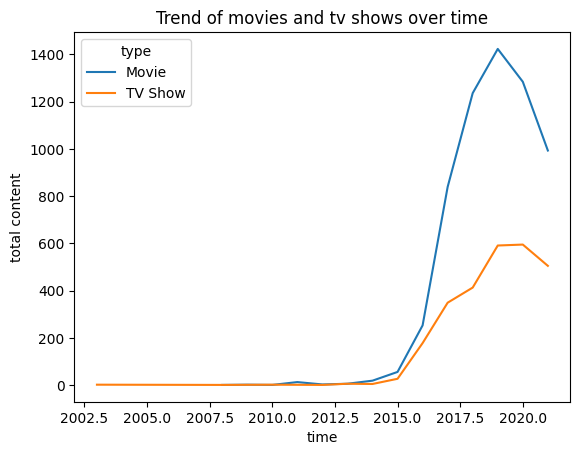

In [595]:
data = df.groupby(["type", "year_added"])["title"].nunique()\
.reset_index()
sns.lineplot(data=data, x="year_added", y="title", hue="type")
plt.ylabel("total content")
plt.xlabel("time")
plt.title("Trend of movies and tv shows over time")
plt.show()

* **Insights**:\
Between 2016 and 2019, there was a significant surge in the total number of movies and TV shows. However, after 2019, there was a rapid decline in the production of both types of content. One plausible explanation for this decline is the global pandemic caused by COVID-19. The pandemic resulted in restrictions and challenges that hindered the creation of new content across the world, leading to a decrease in production.

### 2. How duration affects the total movies/shows

In [596]:
data = df.groupby(["type", "date_added"]).agg({"title":"count", "duration": "mean"}).reset_index().drop(1013, axis=0)

Text(0.5, 1.0, 'Relation between duration and total movies/shows')

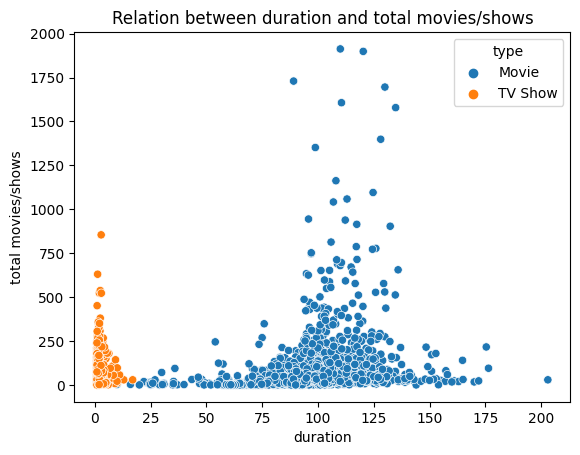

In [597]:
sns.scatterplot(data=data, x="duration", y="title", hue="type")
plt.ylabel("total movies/shows")
plt.title("Relation between duration and total movies/shows")

* **Insights**:
1. The majority of movies have a duration ranging from 100 to 125 minutes, indicating that the optimal duration for a movie falls within this range.

2. Majority of TV shows have only one season, and the total number of TV shows gradually decreases as the number of seasons increases. This phenomenon can be attributed to several factors. Firstly, many TV shows do not perform well, leading producers to avoid creating additional seasons. Additionally, as TV shows progress through multiple seasons, there is often a decline in quality, resulting in decreased viewership. Consequently, this decline in popularity leads to fewer views, ultimately leading the makers to discontinue the show.

### 3. How the duration of movies and tv shows changes with time

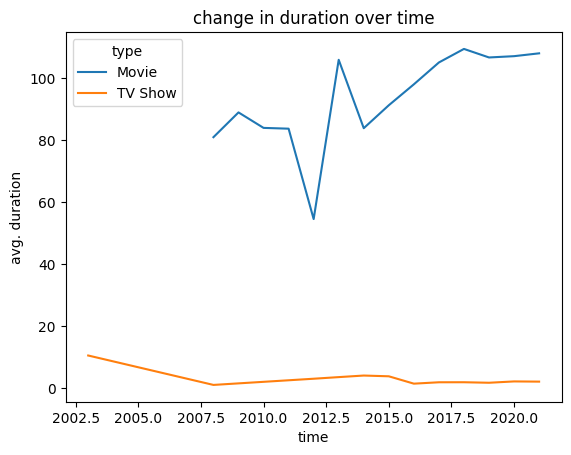

In [598]:
data = df.groupby(["type", "year_added"])["duration"].mean().reset_index()
sns.lineplot(data=data, x="year_added", y="duration", hue="type")
plt.xlabel("time")
plt.ylabel("avg. duration")
plt.title("change in duration over time")
plt.show()

* **Insights**:
1. As time has passed, there has been an observable trend of movies having longer average durations compared to previous years. This indicates that movies nowadays tend to be longer in length.

2. But, when it comes to TV shows, there has been a slight decrease in the average number of seasons. This suggests that TV shows are more inclined to have a lower number of seasons on average than they did in the past. This could be attributed to various factors, including the possibility that recent TV shows have failed to capture the attention of the audience, resulting in fewer seasons being produced.

### 4. How number of movies/tv shows changes with respect to year difference

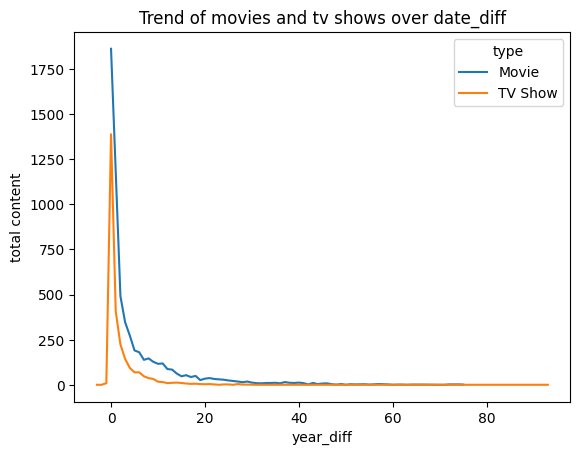

In [599]:
data = df.groupby(["type", "year_diff"])["title"].nunique().reset_index().drop(0, axis=0)
sns.lineplot(data=data, x="year_diff", y="title", hue="type")
plt.ylabel("total content")
plt.xlabel("year_diff")
plt.title("Trend of movies and tv shows over date_diff")
plt.show()

* **Insights**:\
There is a higher likelihood of success for movies and TV shows when they are added to Netflix soon after their release, as evidenced by the larger number of titles available with a smaller date difference. This implies that a quick addition to the Netflix platform significantly increases the probability of achieving success for these movies and TV shows.

## Indepth Analysis on Top 5 Countries

## Analysis on Movie Type

In [600]:
# top_5 
top_5_country = df[df["type"]=="Movie"]["country"].value_counts().iloc[:5].index
top_5 = df[(df["country"].isin(top_5_country)) & (df["type"]=="Movie")]

### 1. Best day to add the movies in top 5 Countries

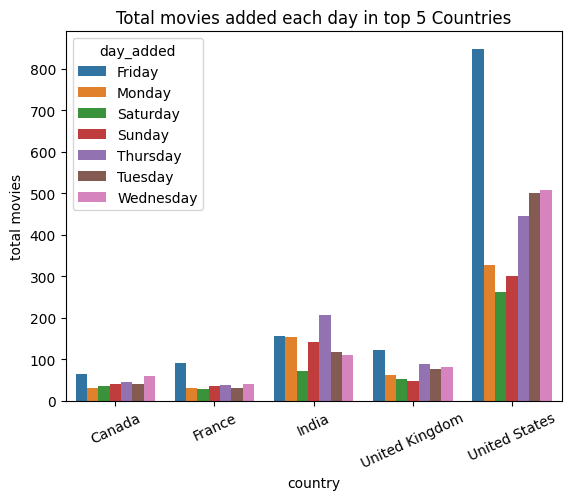

In [601]:
data = top_5.groupby(["country", "day_added"])["title"].nunique().reset_index()
sns.barplot(data=data, x="country", y='title', hue="day_added", estimator="sum")
plt.ylabel("total movies")
plt.xticks(rotation=25)
plt.title("Total movies added each day in top 5 Countries")
plt.show()

* **Insights**:\
In the top five countries, excluding India, Friday is considered the optimal day to release movies on Netflix. However, in India, Thursday is slightly better than Friday for movie releases.

### 2. Best Month to add the movies in top 5 Countries

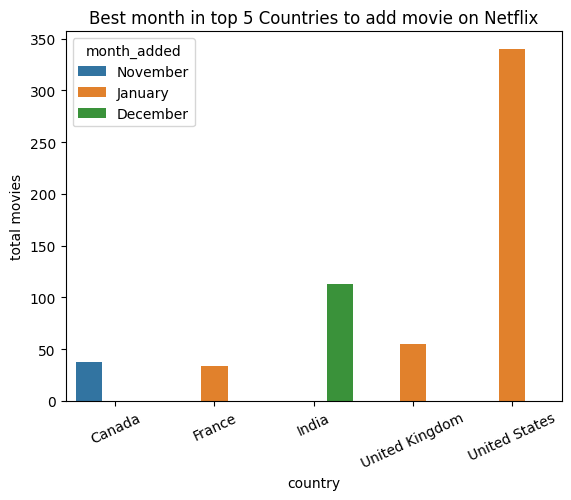

In [602]:
data = top_5.groupby(["country", "month_added"])["title"].nunique().reset_index()
sub_data = data.groupby("country")["title"].max().reset_index()
sns.barplot(data=data.merge(sub_data, on=["country", "title"], how="inner"),\
            x="country", y="title", hue="month_added")
plt.xlabel("country")
plt.ylabel("total movies")
plt.xticks(rotation=25)
plt.title("Best month in top 5 Countries to add movie on Netflix")
plt.show()

* **Insights**:\
In the top five countries, a significant number of movies were added to Netflix during the months of November, December, and January. These months align with the winter season, suggesting that audiences have a preference for watching movies during this time. Therefore, it can be inferred that the winter season is considered the best season to list movies on Netflix in these countries, as it corresponds with increased viewership and interest in movie-watching.

### 3. Best duartion of a movie in top 5 Countries

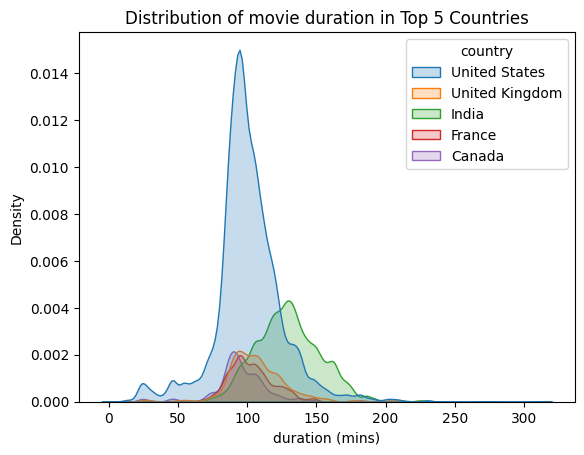

In [603]:
sns.kdeplot(data=top_5, x="duration", hue="country", fill=True)
plt.xlabel("duration (mins)")
plt.title("Distribution of movie duration in Top 5 Countries")
plt.show()

* **Insights**:\
In the top five countries, except India, the best duration for movies typically falls within the range of 90-100 minutes. However, in India, the preferred duration for movies is around 140 minutes, which is slightly longer compared to the other top five countries.

### 4. How the count of total movies changes over time in top 5 countries

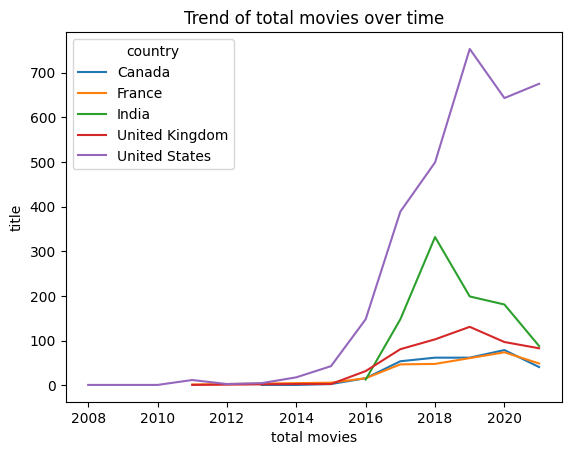

In [604]:
data = top_5.groupby(["country", "year_added"])["title"].nunique().reset_index()
sns.lineplot(data=data,x="year_added", y="title", hue="country")
plt.xlabel("total movies")
plt.title("Trend of total movies over time")
plt.show()

* **Insights**:\
There is rapid increase in the total movies added on Netflix platform in between 2016-2019 years, especially in USA and India. Between 2016 and 2019, there was a notable and rapid increase in the total number of movies added to the Netflix platform, particularly in the USA and India. However, after 2019, there has been a decline in the overall number of movies, with India experiencing a particularly significant decrease.
One potential reason for this decline in India could be attributed to a sudden shift in audience preferences towards web series and international TV shows. This change in viewers' interests might have led content creators and Netflix to focus more on producing and promoting web series and international TV shows rather than movies, resulting in a decline in the number of Indian movies added to the platform.

### 5. Best movie actor and director in top 5 countries

In [605]:
# Actor
data = top_5.groupby(["country", "cast"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
actor_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
actor_data.columns = ["Country", "Actor", "Total movies", "Duration (mean)"]
actor_data

,Country,Actor,Total movies,Duration (mean)
4,United States,James Franco,589,79.475382
2,India,Anupam Kher,132,133.818182
3,United Kingdom,Ashley Chin,117,91.641026
0,Canada,Colm Feore,62,87.677419
1,France,Wille Lindberg,54,84.851852


In [606]:
# Director
data = top_5.groupby(["country", "director"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
director_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
director_data.columns = ["Country", "Director", "Total movies", "Duration (mean)"]
director_data

,Country,Director,Total movies,Duration (mean)
4,United States,Akiva Schaffer,859,65.230501
2,India,Anurag Kashyap,274,123.697080
0,Canada,Robert Vince,163,72.693252
3,United Kingdom,Ben Wheatley,121,90.702479
1,France,Thierry Donard,99,96.121212


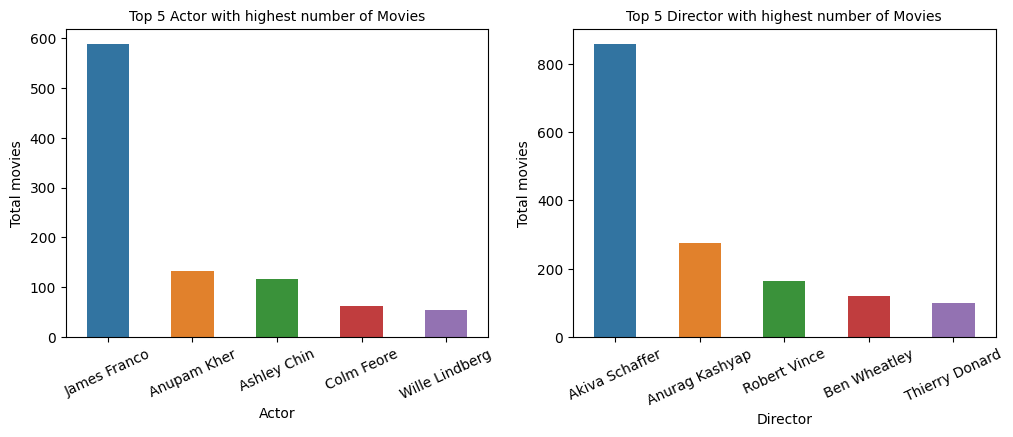

In [607]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(data=actor_data, x="Actor", y="Total movies", width=0.5)
plt.title("Top 5 Actor with highest number of Movies", fontsize=10)
plt.xticks(rotation=25)
plt.subplot(1,2,2)
sns.barplot(data=director_data, x="Director", y="Total movies", width=0.5)
plt.title("Top 5 Director with highest number of Movies", fontsize=10)
plt.xticks(rotation=25)
plt.show()

* **Insights**:
1. James Franco's movies are popular in the USA, while Anupam Kher's movies are well-liked in India on Netflix.

2. Akiva Schaffer is a renowned director in the USA, while Anurag Kashyap holds popularity among Indian audiences.

3. It is observed that the optimal duration for Anurag Kashyap's movies is around 124 minutes. Therefore, his movies with a runtime of approximately 124 minutes have a higher probability of being successful or well-received ("HIT").

### 6. Best genre (listed_in) in top 5 countries

In [608]:
data = top_5.groupby(["country", "listed_in"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
genre_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
genre_data.columns = ["Country", "Genre", "Total movies", "Duration (mean)"]
genre_data

,Country,Genre,Total movies,Duration (mean)
4,United States,Comedies,9171,95.275979
2,India,International Movies,7059,129.804505
3,United Kingdom,Dramas,1948,111.805955
1,France,International Movies,1740,104.251724
0,Canada,Comedies,1017,92.327434


* **Insights**:\
In the USA, comedies are considered the best genre on Netflix, whereas in India, the preferred genre is international movies. This indicates that the Indian audience has a preference for watching international content on Netflix. Additionally, even within the category of international movies, Indian viewers tend to favor longer-duration films.

### 7. Best rating in top 5 countries

In [609]:
data = top_5.groupby(["country", "rating"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
rating_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
rating_data.columns = ["Country", "Rating", "Total movies", "Duration (mean)"]
rating_data

,Country,Rating,Total movies,Duration (mean)
4,United States,R,13663,107.944449
2,India,TV-14,12021,133.510856
3,United Kingdom,R,3048,109.214895
1,France,TV-MA,2707,102.050240
0,Canada,R,1496,100.827540


* **Insights**:\
In the USA, UK, and Canada, R-rated movies are more popular among audiences, while in India, the preference leans towards TV-14 rated movies. Here also we can observe that the Indian audience tends to have a preference for movies with longer durations.

## Analysis on TV Show Type

In [610]:
# top_5
top_5_show = df[df["type"]=="TV Show"]["country"].value_counts().iloc[:5].index
top_5 = df[(df["country"].isin(top_5_show)) & (df["type"]=="TV Show")]

### 1. Best day to add TV Show in top 5 Countries

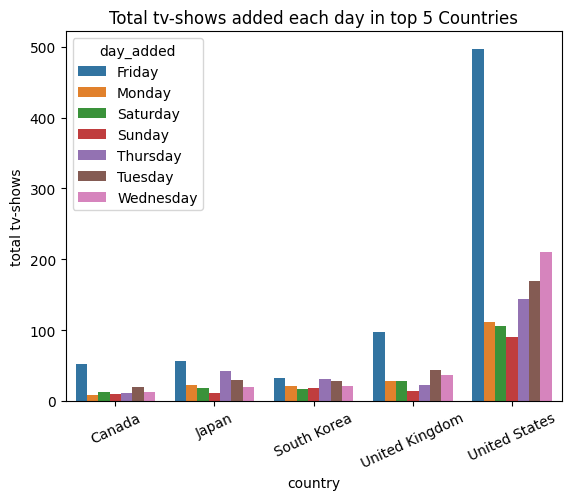

In [611]:
data = top_5.groupby(["country", "day_added"])["title"].nunique().reset_index()
sns.barplot(data=data, x="country", y='title', hue="day_added", estimator="sum")
plt.ylabel("total tv-shows")
plt.xticks(rotation=25)
plt.title("Total tv-shows added each day in top 5 Countries")
plt.show()

* **Insights**:\
The best day to add movie on the Netflix is'Friday' in the top 5 countries.

### 2. Best Month to add the tv shows in top 5 Countries

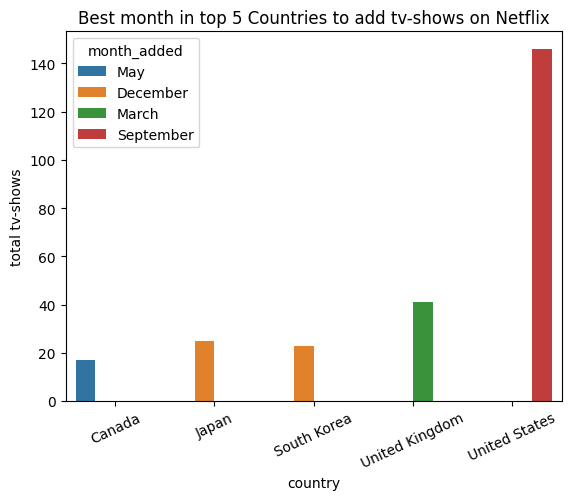

In [612]:
data = top_5.groupby(["country", "month_added"])["title"].nunique().reset_index()
sub_data = data.groupby("country")["title"].max().reset_index()
sns.barplot(data=data.merge(sub_data, on=["country", "title"], how="inner"),\
            x="country", y="title", hue="month_added")
plt.xlabel("country")
plt.ylabel("total tv-shows")
plt.xticks(rotation=25)
plt.title("Best month in top 5 Countries to add tv-shows on Netflix")
plt.show()

* **Insights**:\
Unlike movies, where seasonality trends are observed in different top five countries, TV shows do not exhibit a clear pattern in terms of the months they are added. The addition of TV shows to Netflix in these countries does not show a consistent seasonality favor or trend.

### 3. Best duartion of a TV Show in top 5 Countries

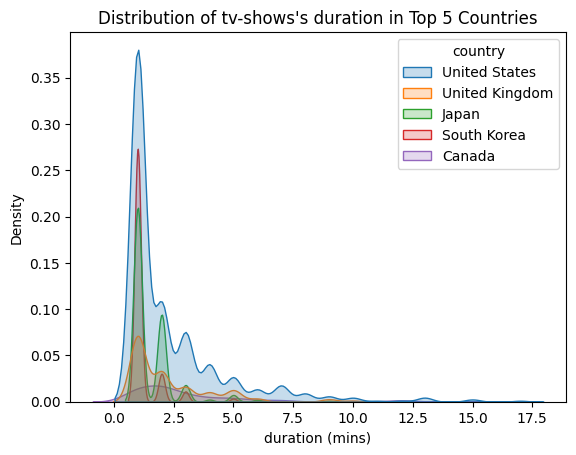

In [613]:
sns.kdeplot(data=top_5, x="duration", hue="country", fill=True)
plt.xlabel("duration (mins)")
plt.title("Distribution of tv-shows's duration in Top 5 Countries")
plt.show()

* **Insights**:\
In the top countries, there is a trend observed where the number of TV shows decreases as the number of seasons increases. This suggests that many TV shows do not achieve success beyond their initial seasons. The decline in the number of TV shows as seasons progress indicates that subsequent seasons may struggle to maintain viewership or fail to attract the same level of interest as the initial season.

### 4. How the count of total tv shows changes over time in top 5 countries

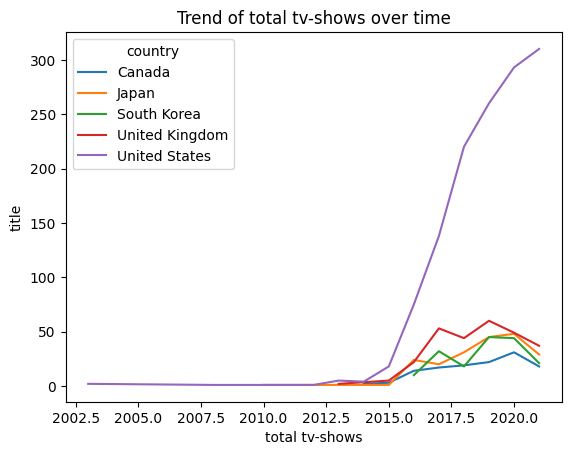

In [614]:
data = top_5.groupby(["country", "year_added"])["title"].nunique().reset_index()
sns.lineplot(data=data,x="year_added", y="title", hue="country")
plt.xlabel("total tv-shows")
plt.title("Trend of total tv-shows over time")
plt.show()

* **Insights**:\
From 2015 onwards, the United States has experienced a significant increase in the total number of TV shows per year compared to other top countries. This suggests that the US television industry has witnessed a rapid growth in TV show production during this period, outpacing other countries in terms of the number of new shows introduced each year.   

### 5. Best tv-show actor and director in top 5 countries

In [615]:
# Actor
data = top_5.groupby(["country", "cast"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
actor_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
actor_data.columns = ["Country", "Actor", "Total tv-shows", "Duration (mean)"]
actor_data

,Country,Actor,Total tv-shows,Duration (mean)
4,United States,Grey Griffin,458,1.375546
3,United Kingdom,David Attenborough,146,1.164384
1,Japan,Takahiro Sakurai,60,1.416667
0,Canada,John Dunsworth,22,3.545455
2,South Korea,Bae Doona,17,1.176471


In [616]:
# Director
data = top_5.groupby(["country", "director"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
director_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
director_data.columns = ["Country", "Director", "Total tv-shows", "Duration (mean)"]
director_data

,Country,Director,Total tv-shows,Duration (mean)
4,United States,Rob Seidenglanz,14904,2.330851
1,Japan,Thomas Astruc,3253,1.540117
3,United Kingdom,Noam Murro,3231,2.246982
2,South Korea,Thomas Astruc,2905,1.249914
0,Canada,Stefan Brogren,1756,3.147494


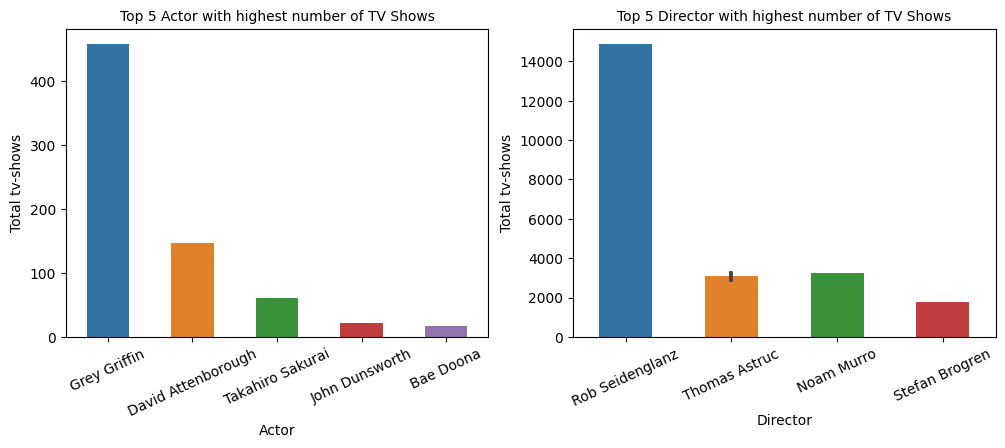

In [617]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(data=actor_data, x="Actor", y="Total tv-shows", width=0.5)
plt.title("Top 5 Actor with highest number of TV Shows", fontsize=10)
plt.xticks(rotation=25)
plt.subplot(1,2,2)
sns.barplot(data=director_data, x="Director", y="Total tv-shows", width=0.5)
plt.title("Top 5 Director with highest number of TV Shows", fontsize=10)
plt.xticks(rotation=25)
plt.show()

* **Insights**:
1. In the USA, TV shows featuring Grey Griffin are popular on Netflix, while in the UK, TV shows featuring David Attenborough gather significant popularity on the platform.

2. In the USA, Rob Seidenglanz is a well-known director, while in Japan, Thomas Astruc holds popularity among audiences.

### 6. Best genre (listed_in) in top 5 countries

In [618]:
data = top_5.groupby(["country", "listed_in"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
genre_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
genre_data.columns = ["Country", "Genre", "Total tv-shows", "Duration (mean)"]
genre_data

,Country,Genre,Total tv-shows,Duration (mean)
4,United States,TV Dramas,3419,2.490494
1,Japan,International TV Shows,1809,1.546711
3,United Kingdom,British TV Shows,1338,2.386398
2,South Korea,International TV Shows,1184,1.130068
0,Canada,Kids' TV,534,2.288390


### 7. Best rating in top 5 countries

In [619]:
data = top_5.groupby(["country", "rating"]).agg({"type":"count", "duration": "mean"})\
.reset_index()
sub_data = data.groupby("country")["type"].max().reset_index()
rating_data = data.merge(sub_data, on=["country", "type"], how="inner")\
.sort_values("type", ascending=False)
rating_data.columns = ["Country", "Rating", "Total tv-shows", "Duration (mean)"]
rating_data

,Country,Rating,Total tv-shows,Duration (mean)
4,United States,TV-MA,9210,2.239414
3,United Kingdom,TV-MA,2607,2.343690
1,Japan,TV-14,2115,1.597163
2,South Korea,TV-14,1986,1.166667
0,Canada,TV-MA,758,3.724274


# Top Insights & Recommendation

1. Between 2016 and 2019, there was a significant rise in the total number of movies and TV shows. However, after 2019, there was a sharp decline in the production of both types of content. One possible explanation for this decline is the global pandemic caused by COVID-19. During this time, restrictions and challenges related to the pandemic may have limited the opportunities for creating new content, resulting in a decrease in production.


2. From 2015 onwards, the United States has experienced a notable surge in the total number of TV shows compared to other leading countries.


3. As time has passed, there has been an observable trend of movies having longer average durations compared to previous years. This indicates that movies nowadays tend to be longer in length. But, when it comes to TV shows, there has been a slight decrease in the average number of seasons. This suggests that TV shows are more inclined to have a lower number of seasons on average than they did in the past. This could be attributed to various factors, including the possibility that recent TV shows have failed to capture the attention of the audience, resulting in fewer seasons being produced.


4. The majority of movies have a duration ranging from 100 to 125 minutes, suggesting that this range is considered optimal. Similarly, many TV shows consist of only one season, and the total number of TV shows gradually declines as the number of seasons increases. This phenomenon can be attributed to the fact that many TV shows fail to resonate with audiences, leading creators to avoid producing additional seasons. Additionally, as TV shows progress through multiple seasons, there is often a decline in quality, resulting in decreased viewership. Consequently, producers may choose to discontinue the series altogether.


5. In the top five countries, excluding India, Friday is considered the optimal day to release movies on Netflix. However, in India, Thursday is slightly better than Friday for movie releases. On the other hand, when it comes to TV shows, Friday remains the best day to add them to Netflix.


6. In the top five countries, a significant number of movies were added to Netflix during the months of November, December, and January. These months correspond to the winter season, suggesting that audiences have a preference for watching movies during this time. Thus, the winter season can be considered the best season to list movies on Netflix in these countries.\
On the other hand, in the top five countries, TV shows do not exhibit a clear seasonal pattern for their addition to Netflix. TV shows are added in different months in different country, indicating that there is no specific seasonality trend or preference when it comes to releasing TV shows on Netflix.


7. The average duration of movies in India is generally higher compared to other countries. This indicates that Indian audiences have a preference for longer movies.


8. The majority of movies listed on Netflix in India are international movies. This suggests that Indian audiences have a preference for watching international content on the platform. Furthermore, even within the category of international movies, the Indian audience tends to favor longer-duration films.


9. After 2019, there has been a decline in the overall number of movies in India. One potential reason for this decline in India could be attributed to a sudden shift in audience preferences towards web series and international TV shows. This change in viewers' interests might have led content creators and Netflix to focus more on producing and promoting web series and international TV shows rather than movies, resulting in a decline in the number of Indian movies added to the platform.


10. There is a higher likelihood of success for movies and TV shows when they are added to Netflix soon after their release, as evidenced by the larger number of titles available with a smaller date difference. This implies that a quick addition to the Netflix platform significantly increases the probability of achieving success for these movies and TV shows.